In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.metrics import v_measure_score
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
!pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score



In [2]:
train_df=pd.read_csv('mitbih_train.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)

c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

In [3]:
print(train_df.shape)
print(test_df.shape)

(87554, 188)
(21892, 188)


In [4]:
#garder uniquement 10'000 lignes de train_df
train_df=train_df.sample(10000)
print(train_df.shape)
print(test_df.shape)

(10000, 188)
(21892, 188)


c:\Users\antho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


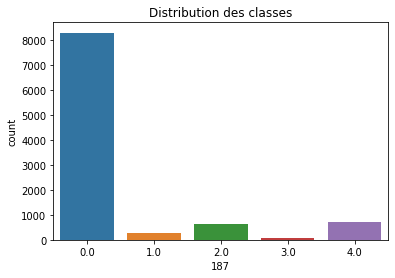

In [5]:
#montrer la distribution des classes
sns.countplot(train_df[187])
plt.title('Distribution des classes')
plt.show()

# Histogramm de la répartition

In [6]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)
test_df[187]=test_df[187].astype(int)
equilibre_test=test_df[187].value_counts()
print(equilibre_test)


0    8299
4     732
2     626
1     259
3      84
Name: 187, dtype: int64
0    18118
4     1608
2     1448
1      556
3      162
Name: 187, dtype: int64


affichage de la répartition par classe 

# Pre traitement

### Rééquilibrage ?

### Stockage des cibles

In [7]:
y_train=train_df[187].values
y_test=test_df[187].values

### Ajout de bruit ?

### Normalisation

In [8]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

# Scale time series
scaler = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_2D = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_test_scaled_2D = X_test_scaled.reshape(X_test_scaled.shape[0], -1)



X_train_r = X_train.reshape(len(X_train), X_train.shape[1])
X_test_r = X_test.reshape(len(X_test), X_test.shape[1])


TimeSeriesScalerMeanVariance prends en comptes les caractéristiques uniques des données de séries temporelles. (ce que ne fait pas un simple reshape) Ainsi, chaque série temp. contribue de manière égale à l'algorithme de regroupement

# Clustering KMeans

In [9]:


# définir le nombre de clusters
n_clusters = 5

# Initialiser le modèle KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Entraîner le modèle sur les données d'entraînement
kmeans.fit(X_train_r)

# Prédire les clusters pour les données de test
y_pred = kmeans.predict(X_test_r)

# Evaluer la performance en utilisant l'indice d'adjacent V-measure

v_measure = v_measure_score(y_test, y_pred)
print("V-measure:", v_measure)


# Calcul de l'indice de Rand ajusté
ari = adjusted_rand_score(y_test, y_pred)

print("Indice de Rand ajusté :", ari)

V-measure: 0.08890342025508699
Indice de Rand ajusté : 0.09808171290629565


0.088 indique que les clusters formés ne sont pas très performants et qu'il est nécessaire de faire des ajustements supplémentaires pour améliorer la qualité du clustering. 0 min, 1 max pour des clusters parfait

In [10]:
# Évaluer les résultats avec le score de silhouette
silhouette_score_init = silhouette_score(X_test, y_pred)
print("Score de silhouette initial:",silhouette_score_init)

Score de silhouette initial: 0.17578889467352024


Pour la métrique silhouette, le min est -1 et le max 1. Plus le score est proche de 1, plus les clusters sont bien définis. Ici, le score initiale est 0.18.

In [11]:
#calculer le pourcentage de données mal classées
y_pred=kmeans.predict(X_test)
misclassified_samples=np.where(y_pred!=y_test)[0]
print("Pourcentage de données mal classées:",len(misclassified_samples)/len(y_test)*100)

Pourcentage de données mal classées: 92.37621048784945


In [12]:
def correct_clustering_percentage(conf_mat):
    # Sum the maximum values in each row (i.e., the largest cluster for each class)
    correct_clustering = np.sum(np.amax(conf_mat, axis=1))

    # Calculate the total number of samples
    total_samples = np.sum(conf_mat)

    # Calculate the correct clustering percentage
    correct_clustering_percentage = correct_clustering / total_samples * 100

    return correct_clustering_percentage


def percentage_with_diag(conf_mat):
    # Calculate the correct clustering percentage using the diagonal elements
    correct_clustering_percentage_diag = np.sum(np.diag(conf_mat)) / np.sum(conf_mat) * 100

    return correct_clustering_percentage_diag

from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(conf_mat)

# Calculate and print the correct clustering percentage
print("Correct clustering percentage:", correct_clustering_percentage(conf_mat))

# Calculate and print the correct clustering percentage using the diagonal elements
print("Percentage with diag:", percentage_with_diag(conf_mat))


Confusion matrix:
[[ 905 4614 2674 9184  741]
 [  32  225  138  154    7]
 [ 288  276  425  338  121]
 [   1   47    0  113    1]
 [ 881   75  376  275    1]]
Correct clustering percentage: 49.4609903160972
Percentage with diag: 7.623789512150557


# Clustering DBSCAN

In [20]:
from sklearn.cluster import DBSCAN
from itertools import product

# Create a range of values for eps and min_samples
eps_values = np.arange(0.2, 0.6, 0.1)
min_samples_values = np.arange(5, 30, 5)

# Create a grid of parameter combinations
parameter_grid = list(product(eps_values, min_samples_values))

best_eps = 0
best_min_samples = 0
best_correct_clustering_percentage = 0

# Grid search for the best combination of eps and min_samples
for eps, min_samples in parameter_grid:
    # Initialize the DBSCAN model with the current combination of eps and min_samples
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the training data
    dbscan.fit(X_train_r)

    # Predict the cluster labels for the test data
    y_pred = dbscan.fit_predict(X_test_r)

    # Calculate the confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)

    # Calculate the correct clustering percentage for the current combination
    current_correct_clustering_percentage = correct_clustering_percentage(conf_mat)

    # Update the best combination if the current combination is better
    if current_correct_clustering_percentage > best_correct_clustering_percentage:
        best_correct_clustering_percentage = current_correct_clustering_percentage
        best_eps = eps
        best_min_samples = min_samples

# Print the best combination of eps and min_samples, and the corresponding best correct clustering percentage
print("Best eps:", best_eps)
print("Best min_samples:", best_min_samples)
print("Best correct clustering percentage:", best_correct_clustering_percentage)


Best eps: 0.2
Best min_samples: 20
Best correct clustering percentage: 100.0


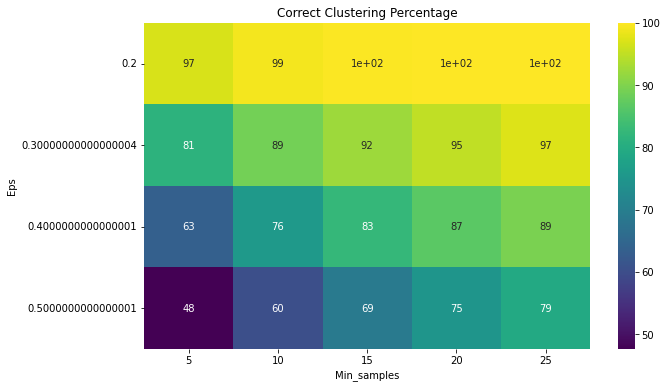

[[ 96.75223826  99.11839942  99.75790243 100.         100.        ]
 [ 81.34478348  88.79042573  92.394482    95.04841951  97.18161886]
 [ 63.44326695  75.72172483  82.61922163  86.65722638  89.44363238]
 [ 47.665814    60.23204824  69.05718984  74.94975333  79.21615202]]


In [31]:
import matplotlib.pyplot as plt

# Initialize an empty array to store the correct clustering percentages
results = np.zeros((len(eps_values), len(min_samples_values)))

# Fill the results array with the correct clustering percentages for each combination of eps and min_samples
for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_train_r)
        y_pred = dbscan.fit_predict(X_test_r)
        conf_mat = confusion_matrix(y_test, y_pred)
        results[i, j] = correct_clustering_percentage(conf_mat)

# Create a heatmap using the results array
plt.figure(figsize=(10, 6))
sns.heatmap(results, annot=True, cmap='viridis', xticklabels=min_samples_values, yticklabels=eps_values)

# Set the labels for the heatmap
plt.xlabel('Min_samples')
plt.ylabel('Eps')
plt.title('Correct Clustering Percentage')

# Show the heatmap
plt.show()

print(results)


In [28]:
# Initialize the DBSCAN model
dbscan = DBSCAN(eps=0.3, min_samples=15)

# Fit the model to the data
dbscan.fit(X_train_r)

# Predict the cluster labels for the test data
y_pred = dbscan.fit_predict(X_test_r)

# Evaluer la performance en utilisant l'indice d'adjacent V-measure
v_measure = v_measure_score(y_test, y_pred)
print("V-measure:", v_measure)

# Evaluate the results using the silhouette score
silhouette_score_init = silhouette_score(X_test_r, y_pred)
print("Score de silhouette initial avec DBSCAN:", silhouette_score_init)

# Calculating the percentage of misclassified data
misclassified_samples = np.where(y_pred != y_test)[0]
print("Percentage of misclassified data:", len(misclassified_samples) / len(y_test) * 100)

# Calcul de l'indice de Rand ajusté
ari = adjusted_rand_score(y_test, y_pred)

print("Indice de Rand ajusté :", ari)


V-measure: 0.026548254003523078
Score de silhouette initial avec DBSCAN: -0.31150400566203895
Percentage of misclassified data: 98.58395761008587
Indice de Rand ajusté : -0.09958644317749488


In [29]:

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(conf_mat)

# Calculate and print the correct clustering percentage
print("Correct clustering percentage:", correct_clustering_percentage(conf_mat))

# Calculate and print the correct clustering percentage using the diagonal elements
print("Percentage with diag:", percentage_with_diag(conf_mat))

Confusion matrix:
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [16455   310    52    60    28   447    52    39    25    31    42    33
    107    28    51    27    25    23    25    34    21    32    44    17
     31    16    17    15    16    15]
 [  556     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [ 1448     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [  160     0     0     2     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [ 1608     0     0     0     0     0     0    

In [30]:
# Get the unique cluster labels in y_pred
unique_labels = np.unique(y_pred)

# Exclude the noise label (-1) from the count
num_clusters = len(unique_labels) - 1 if -1 in unique_labels else len(unique_labels)

# Print the number of clusters
print("Nombre de clusters :", num_clusters)


Nombre de clusters : 29
